In [ ]:
from camp2ascii import camp2ascii as c2a
import pandas as pd
from pathlib import Path

tob3_file_names = sorted(f.name for f in Path("tests/tob3").glob("*10Hz*.dat"))
# tob3_file_names = [tob3_file_names[0]]
# tob3_file_names = ["60955.CS616_30Min_UF_40.dat", "60955.CS616_30Min_UF_41.dat", "60955.CS616_30Min_UF_42.dat"]

tob3_files = [Path(f"tests/tob3/{name}") for name in tob3_file_names]
toa5_cc_file_names = [Path(f"tests/toa5-cc/TOA5_{name}") for name in tob3_file_names]
toa5_c2a_dir = Path("tests/toa5-c2a")


# out_files = c2a(tob3_files, toa5_c2a_dir, pbar=True)
out_files = list(toa5_c2a_dir.glob("*10Hz*.dat"))

c2a_data = pd.concat([pd.read_csv(f, skiprows=[0, 2, 3], parse_dates=["TIMESTAMP"], index_col="TIMESTAMP") for f in out_files]).sort_index()
cc_data = pd.concat([pd.read_csv(f, skiprows=[0, 2, 3]) for f in toa5_cc_file_names])
cc_data["TIMESTAMP"] = pd.to_datetime(cc_data["TIMESTAMP"], format="ISO8601")
cc_data = cc_data.set_index("TIMESTAMP").sort_index()

In [5]:
extra_c2a = sorted(set(c2a_data.index) - set(cc_data.index))

len(extra_c2a)/864000

0.9411319444444445

In [ ]:
import numpy as np


np.float64(1.0)

<Axes: xlabel='TIMESTAMP'>

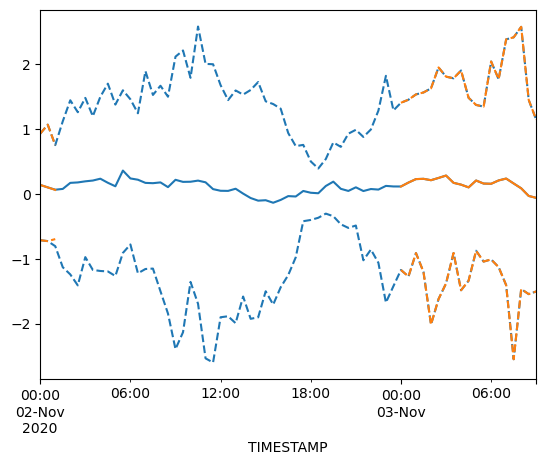

In [33]:
c2a_data.shape[0]/864000

col = "Ux"
c2a_data.resample("30min").min()[col].plot(color="C0", style="--")
c2a_data.resample("30min").max()[col].plot(color="C0", style="--")
c2a_data.resample("30min").mean()[col].plot(color="C0", style="-")
cc_data.resample("30min").min()[col].plot(color="C1", style="--")
cc_data.resample("30min").max()[col].plot(color="C1", style="--")
cc_data.resample("30min").mean()[col].plot(color="C1", style="-")